<a href="https://colab.research.google.com/github/read-project/machine-learning-models/blob/main/Draw/Draw_Classif_NN_Predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Common Setup

In [ ]:
#!pip install imgaug
!pip install git+https://github.com/aleju/imgaug.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/aleju/imgaug.git to /tmp/pip-req-build-ujc47jl6
  Running command git clone --filter=blob:none --quiet https://github.com/aleju/imgaug.git /tmp/pip-req-build-ujc47jl6
  Resolved https://github.com/aleju/imgaug.git to commit 0101108d4fed06bc5056c4a03e2bcb0216dac326
  Preparing metadata (setup.py) ... done


In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import pathlib
from matplotlib import pyplot as plt
import glob

from tensorflow.keras.applications import ResNet50, VGG16

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from collections import Counter

import imageio

from keras.utils.vis_utils import plot_model

from tensorboard.plugins import projector
import cv2
import shutil
import sklearn

import imgaug as ia
import imgaug.augmenters as iaa
import json
from PIL import Image
import pickle
import gc
from keras.callbacks import TensorBoard
from imblearn.over_sampling import RandomOverSampler

In [ ]:
!pip list | grep tensorflow

tensorflow                    2.12.0
tensorflow-datasets           4.9.2
tensorflow-estimator          2.12.0
tensorflow-gcs-config         2.12.0
tensorflow-hub                0.13.0
tensorflow-io-gcs-filesystem  0.32.0
tensorflow-metadata           1.13.1
tensorflow-probability        0.20.1


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 17.5 MB/s eta 0:00:00


In [ ]:
from tensorflow_addons.optimizers import AdamW

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


# Init

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
batch_size = 16
img_height = 224
img_width = 224

LABELS= ['Plan','Elevation','Section','Others']

THRESHOLD_FILE='clf_NN_multi_thresholds.pk'

In [ ]:
DATA_FOLDER= 'Test'        #This is the image and metadata folder
MODELS_FOLDER= 'Models'   #This is where you want to store trained models

In [ ]:
LS_FILE= 'label-studio_export.json'    #Label Studio export file (metadata file)
MODEL_FILE= 'clf_NN_multi_2.h5'

SPLIT_TRAIN_TEST=0.30   #Perc. split
SPLIT_TRAIN_VAL= 0.20   #Perc. split
NORM_IMAGE= False       #if True than normalise between [0,1]
                        # WARNING! All images must have numpy's dtype uint8. Values are expected to be in
                        # range 0-255
BW_IMAGE= False         #if True than images are transformed in black and white

print('Data folder:',DATA_FOLDER)

Data folder: Test


## Copy data from Drive

In [ ]:
#Copy models folder
!cp -r  '/content/gdrive/MyDrive/Colab Notebooks/ReAD/02_Draw/'$MODELS_FOLDER /content

In [ ]:
#Copy Images
!cp -r  '/content/gdrive/MyDrive/Colab Notebooks/ReAD/02_Draw/'$DATA_FOLDER /content

## Def. Common functions

In [ ]:
from operator import is_
#Files

def my_mkdir(folder, verbose=False):
  '''
  Create folder if dosn't exists
  '''
  try:
    #folder= os.path.join(os.getcwd(), folder)
    if verbose:
      print('Creating folder', folder, end='' )
    os.mkdir(folder)
    if verbose:
      print('...done.')
  except OSError as e:
    #pass
    if verbose:
      print('...NOT created!!! ',e)

def save_model(model, file_name='my_model.h5', verbose=True):
  '''
  Save model to file_name
  '''
  if verbose:
    print('Saving model',type(model).__name__,'to file',file_name, end='')
  res =pickle.dump(model, open(file_name, 'wb'))
  if verbose:
    print('...done.')
  return res

def load_model(file_name='my_model.h5', verbose=True):
  '''
  Load model from file_name
  Return model
  '''
  if verbose:
    print('Loading model from',file_name, end='')
  model =pickle.load(open(file_name, 'rb'))
  if verbose:
    print('...done.')
  return model

def check_img(f, verbose=False):
  '''
  Check if file exists and format is ok
  '''
  is_ok=True
  try:
    im = Image.open(f)
    im.verify()
    im.close()
    if verbose:
      print(f"OK: {f}")
  except (IOError, OSError, Image.DecompressionBombError):
    is_ok= False
    if verbose:
      print(f"Fail: {f}")

  if verbose :print('file check res:',is_ok)
  return is_ok

'''
#Use this for TENSORFLOW
def decode_img(img, norm=False, b_w=False, img_height=224, img_width=244):
  # Convert the compressed string to a 3D uint8 tensor

  img= tf.io.decode_jpeg(img, channels=3, dct_method='INTEGER_ACCURATE')
  if b_w:
    img= tf.image.rgb_to_grayscale(img)
  if norm:
    img=img/255
  # Resize the image to the desired size

  return tf.image.resize(img, [img_height, img_width], method='bilinear' )

def process_path(file_path, label, norm= False, b_w= False, img_height=224, img_width=224):
  # Load the raw data from the file as a string
  img = tf.io.read_file( file_path)
  img = decode_img(img, norm, b_w, img_height, img_width)
  return img, label
'''

def decode_img(img, norm=False, b_w=False, img_height=224, img_width=244, aug_contrast=True):
  #Use OpenCV

  if aug_contrast:
    #Augment the contrast of image
    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))
    # Converting image from LAB Color model to BGR color spcae
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

  #Interpolate
  img= cv2.resize(img, (img_width, img_height) , interpolation= cv2.INTER_AREA) # INTER_CUBIC )
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img= np.asarray(img)
  if norm:
    img=img/255
  # Resize the image to the desired size

  return img

def process_path(file_path, label, norm= False, b_w= False, img_height=224, img_width=224, aug_contrast=True):
  # Load the raw data from the file as a string
  try:
    img = cv2.imread(file_path)
    img = decode_img(img, norm, b_w, img_height, img_width, aug_contrast)
    return img
  except:
    return None


def load_from_json(file_and_path,
                   split_perc=0.2,
                   norm= False,
                   b_w= False,
                   LABELS=LABELS,
                   FROM_NAME='choice',
                   DISCARD=[],            #List of label to discard
                   verbose= False):
  '''
  Load images and labels from a Label Studio exported file.
  For each row, try first to load annotations, if not found load predictions.
  Images are shuffled.

  file_and_path: input path+file
  split_perc: parcentage for training and validation test, use 0 to return only training set
  norm: if true, then normalize (image */255)
  b_w: if True, transform in black and white
  verbose: if display logs

  Return:   train dataset,
            validation dataset (tensorflow data),
            list of training file name,
            list of val filename
  '''

  if norm:
    print('WARINING to be augmented values are expected to be in range 0-255, but you request to normalize !! (norm= True)')

  #Load infs from file
  data_file= open(file_and_path)
  jdata_list= json.load(data_file)
  data_file.close()
  print('JSON records', len(jdata_list))

  #Discard elements to one hot
  one_h_DISCARD=[1 if e in DISCARD else 0 for e in LABELS]

  #From json to lists
  file_list=[]
  y_list=[]
  for jdata in jdata_list:
    if verbose:
      print('json:', jdata)
    file_name= jdata.get('data').get('image')
    file_name= os.path.join(DATA_FOLDER, file_name.split('/')[-1])

    #Check if file exists, if don't go for next (don't append)
    is_ok= check_img(file_name)

    #Discard duplicates
    #Eliminata dopo la revisione del db
    #if ('_0'in file_name) or ('_1' in file_name):
    #  is_ok= False

    if not is_ok:
      if verbose: print(file_name,' not ok!\n')
      #next item without append
      continue

    try:
      results_val= jdata.get('annotations')[0].get('result')
      annot_val=''
      for res in results_val:
        if res.get('from_name')== FROM_NAME:
          annot_val= res.get('value').get('choices')
      if len(annot_val)==0:
        raise ValueError
      #annot_val= jdata.get('annotations')[0].get('result')[0].get('value').get('choices')
    except (IndexError, ValueError) as e:
      if verbose: print('annotations not found, try with predictions')
      try:
        annot_val= jdata.get('predictions')[0].get('result')[0].get('value').get('choices')
      except:
        if verbose: print('also prediction not found, assigning manual label (Others)')
        annot_val= LABELS[-1]

    #To one hot
    one_h_annot_val= [1 if ele in annot_val else 0 for ele in LABELS]

    #Filter Error labelling Others+others label at 1
    if (one_h_annot_val[-1]==1) and (sum(one_h_annot_val)>1):
      one_h_annot_val[-1]=0

    #Chack if labels are in DISCARD, if so discard it
    #Example annot=[0,1,0,1]
    #        disc =[0,0,0,1]
    #        mult  [0,0,0,1]
    #        sum    1 so is to discard
    if sum([a*b for a,b in zip(one_h_annot_val,one_h_DISCARD)])>0:
      if verbose:
        print('Label', annot_val,'in', DISCARD,': DISCARTED.\n')
      continue  #discard

    #Good input....add it
    file_list.append(file_name)
    y_list.append(one_h_annot_val)

    if verbose:
      print('File&Path:', file_name, '\nAnnot.:',annot_val, '\nOneHot:',one_h_annot_val,'\n')

  image_count= len(y_list)
  print('Found',image_count,'files')

  #Plot
  #Count and ploat each class
  print('\nSingle class count')
  count = count_each_class(np.array(y_list))
  plot_pet_from_dict(count)                   #plot single class
  print('\n')

  #Count and plot multiple class
  print('\nMultiple class count')
  cnt, unq= count_uniq_rows(np.array(y_list) )
  lab_lst=[]
  for u in unq:
    #print(u)
    lab_lst.append(str([b for a, b in zip(u, LABELS) if a]))
  # Plotting
  plt.bar(lab_lst,cnt,  color='red')
  plt.tick_params(axis='x', rotation=90)
  plt.show()
  print('\n')
  #-End plot---

  #Build dataset
  img_list_ds= pd.DataFrame()
  img_list_ds['X'] = file_list
  img_list_ds['y'] = y_list

  if verbose:
    print(img_list_ds.head(5))
  #Shuffle
  img_list_ds = img_list_ds.sample(frac=1, random_state=3).reset_index(drop=True)  #<<<<<  Shuffle with seed to replicate
  if verbose:
    print(img_list_ds.head(5))

  #Create validation set
  val_size = int(image_count * split_perc)
  train_img_file_ds = img_list_ds[val_size: ]
  val_img_file_ds = img_list_ds[ :val_size]

  train_img_file_list=train_img_file_ds['X']
  print('\nTot n. of example for training', len(train_img_file_list))
  val_img_file_list=val_img_file_ds['X']
  print('Tot n. of example for test', len(val_img_file_list))

  #Load images
  train_ds= pd.DataFrame()
  train_ds['X'] = train_img_file_ds.apply(lambda row : process_path(row['X'],row['y'],
                                                             norm,
                                                             b_w,
                                                             img_height,
                                                             img_width,
                                                             aug_contrast=False),
                                     axis=1
                                  )
  train_ds['y']= train_img_file_ds['y']

  val_ds = pd.DataFrame()
  val_ds['X']   = val_img_file_ds.apply(lambda row : process_path(row['X'],row['y'],
                                                           norm,
                                                           b_w,
                                                           img_height,
                                                           img_width,
                                                           aug_contrast=True),
                                   axis=1
                                )
  val_ds['y']= val_img_file_ds['y']

  #Take only filename
  train_img_file_list= train_img_file_list.tolist()
  val_img_file_list= val_img_file_list.tolist()

  return train_ds, val_ds, train_img_file_list, val_img_file_list

def configure_for_performance(ds, batch_size=8, at=AUTOTUNE):
  ds = ds.cache()
  #ds = ds.shuffle( buffer_size=5000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=at)
  return ds

  import pickle


In [ ]:
#Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#Count and plot
def count_each_class(app_arr, labels=LABELS):
  '''
  Input: array of labels es:  array([[0, 0, 1, 0],
                                     [0, 1, 1, 0],
                                     [0, 0, 0, 0]], dtype=int32)
  count how many examples became from each class (label)
  '''
  res={}
  for i in range(len(LABELS)):
    res[LABELS[i]]= app_arr[:,i].sum()
  return res

def plot_pet_from_dict(your_data):
  '''
  Pie data to plot.
  Input: dictionary
  '''

  labels = []
  sizes = []

  for x, y in your_data.items():
      labels.append(x)
      sizes.append(y)

  # Plot
  plt.pie(sizes,
                  pctdistance = 1.2,
        labeldistance = 1.4,
        autopct=lambda x: f'({(x/100)*sum(sizes):.0f})\n{x:.1f}%',
          labels=labels)

  plt.axis('equal')
  plt.show()

from sklearn.metrics import multilabel_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def binatodeci(binary):
  '''
  Binary number to decimal
  '''
  return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

def multilabel_stat(y,pred,labels=LABELS):
  '''
  Plot confusio metrics and print statistics
  y: true (real output)
  pred: predicted output
  labels: class labels
  '''

  print('Multi-class confusion matrix')
  cm_list = multilabel_confusion_matrix(y, pred).tolist()

  f, axes = plt.subplots(1, 4, figsize=(20, 5))#, sharey='row')

  for i, cm, label in zip(range(len(labels)), cm_list, labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm), display_labels=['All Others', label])

    disp.plot(ax=axes[i], xticks_rotation=45 )
    disp.ax_.set_title('Conf. mat. for class '+label)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

  f.text(0.4, 0.1, 'Predicted label', ha='left')
  plt.subplots_adjust(wspace=0.40, hspace=0.1)
  f.colorbar(disp.im_, ax=axes)
  plt.show()

  print('\nClassification Report (multi label)')
  lab_lst=[]
  for n in range(1,16):
    b= [int(i) for i in bin(n)[2:].zfill(4)]
    lab_lst.append(str([b for a, b in zip(b, LABELS) if a]))

  cl=classification_report(np.array([binatodeci(row) for row in y]),
                          np.array([binatodeci(row) for row in pred]),
                          labels= [x for x in range(1,16)],
                          target_names= lab_lst,
                          zero_division=0,
                          output_dict= True)

  with pd.option_context('display.float_format', '{:0.3f}'.format):
    print(pd.DataFrame.from_dict(dict((k, v) for k, v in cl.items() if v['support'] > 0)).T)


def count_uniq_rows(my_array):
  '''
  Count same rows in numpy array

  Return count array , unique lists of arrays
  '''
  dt = np.dtype((np.void, my_array.dtype.itemsize * my_array.shape[1]))
  b = np.ascontiguousarray(my_array).view(dt)
  unq, cnt = np.unique(b, return_counts=True)
  unq = unq.view(my_array.dtype).reshape(-1, my_array.shape[1])

  return cnt, unq


In [ ]:
transf_list=[
    iaa.Fliplr(1),
    iaa.Flipud(1),
    iaa.Affine(rotate=(-45, 45)),
    iaa.Affine(rotate=(-90, 90)),
    iaa.Affine(scale=(0.5, 2.0)),
    iaa.GaussianBlur(sigma=(0.0, 3.0)),
    iaa.BlendAlpha((0.0, 1.0),foreground=iaa.Add(100),background=iaa.Multiply(0.2)),
    #iaa.LogContrast(gain=(0.6, 0.8)),
    #iaa.AdditiveGaussianNoise(scale=(0, 0.2*255)),
    #iaa.AdditiveLaplaceNoise(scale=(0, 0.2*255)),
    #iaa.MultiplyElementwise((0.5, 1.5)),
    iaa.Cutout(nb_iterations=(1, 5), size=0.1, squared=False, cval=0),
    iaa.Cutout(fill_mode="constant", cval=255),
    iaa.Dropout(p=(0, 0.1)),
    iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.15)),
    iaa.ReplaceElementwise(0.08, [0, 255]),
    iaa.Salt(0.08),
    iaa.Pepper(0.08),
    ]

# seq =iaa.Sometimes(5 / 6, iaa.OneOf(transf_list)
# seq = iaa.OneOf(transf_list)

seq = iaa.SomeOf((1, 4),transf_list)

In [ ]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler

class Aug_Sequence(Sequence):
    '''
    Augment while trining.<br>
    Apply augmentation to the x_set, y_set of batch
    '''
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return  self.augment(images= batch_x), np.array(batch_y)

In [ ]:
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score

# get the model
def get_model(n_inputs, n_outputs):
  model = Sequential()
  model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dense(n_outputs, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy',f1_m])
  return model

 # evaluate a model using repeated k-fold cross-validation
def evaluate_model(X, y):
  results = list()
  n_inputs, n_outputs = X.shape[1], y.shape[1]
  # define evaluation procedure
  cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
  # enumerate folds
  for train_ix, test_ix in cv.split(X):
    # prepare data
    X_train, X_test = X[train_ix,:], X[test_ix,:]
    y_train, y_test = y[train_ix,:], y[test_ix,:]
  # define model
  model = get_model(n_inputs, n_outputs)
  # fit model
  model.fit(X_train, y_train, verbose=0, epochs=100)
  # make a prediction on the test set
  yhat = model.predict(X_test)
  # round probabilities to class labels
  yhat = yhat.round()
  # calculate accuracy
  acc = accuracy_score(y_test, yhat)
  # store result
  print('>%.3f' % acc)
  results.append(acc)
  return results

In [ ]:
def predict_thresholds(model, x_test, thresholds):
  '''
  Predict applying thresholds.
  If [0,0,0,0] is predicted than the class is the most significative also if it doesn't pass threshold.

  model,
  x_test,
  thresholds

  Return Predicted output (Array of boolean lists), Sure level (boolena: 1 sure, 0 not sure).
  For sure level: prediction are not sure il non of val is grather than thresold => [0,0,0,0] but
  the argmax is taken.
  '''
  print('Using optimized thresholds')
  y_pred= model.predict(x_test)

  level= np.ones(y_pred.shape[0])   #livello di sicurezza della predizione

  #Filter by thresholds to binary output
  thr_arr=np.array([t['thr'] for t in thresholds])
  thr_arr=np.tile(thr_arr, (y_pred.shape[0],1))
  res= y_pred> thr_arr
  res = res.astype('int32')
  #Set sure level (if [0,0,0,0] than not a sure prediction)
  level[np.sum(res, axis=1)==0]= 0
  #if all output are all zeros than take the one with highter probab.
  res[np.sum(res, axis=1)==0, np.argmax(y_pred[np.sum(res, axis=1)==0], axis=1)]=1

  return res, level

#Load Data

In [ ]:
image_list = [process_path(item, False, False, img_width, img_height) for i in [glob.glob('/content/'+DATA_FOLDER+'/*.%s' % ext) for ext in ["jpeg","jpg","gif","png"]] for item in i]

In [ ]:
#Remove None
image_list= [x for x in image_list if x is not None]

In [ ]:
print('Loaded', len(image_list),'images.')

Loaded 35 images.


# Model definition

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.multioutput import MultiOutputClassifier
from scikeras.wrappers import KerasClassifier
# optimization method
from keras.optimizers import SGD

In [ ]:
def define_nn_clf(pretrain_mod= 'res',
                  pretrain_trainable= False,
                  use_rescaling= False,
                  n_layers=1,
                  layer_dim=128,
                  layer_reducer= 2,
                  use_dropout= True,
                  dropout= 0.3,
                  use_norm= False,
                  multi_label=False,
                  activation= 'tanh',
                  opt= 'rmsprop',
                  metrics=['accuracy',f1_m],
                  output_shape= 1,
                  verbose= False):

  # Initialize the Pretrained Model
  if pretrain_mod== 'res':
    feature_extractor = ResNet50(weights='imagenet',
                                input_shape=(224, 224, 3),
                                include_top=False)
  else:
    feature_extractor = VGG16(weights='imagenet',
                                input_shape=(224, 224, 3),
                                include_top=False)

  # Set this parameter to make sure it's not being trained
  feature_extractor.trainable = pretrain_trainable

  # Set the input layer
  input_ = tf.keras.Input(shape=(224, 224, 3))

  # Rescaling
  if use_rescaling:
    x= tf.keras.layers.Rescaling(1./255) (input_)
  else:
    x= input_

  # Set the feature extractor layer
  x = feature_extractor(x , training=pretrain_trainable)

  x = tf.keras.layers.Flatten(name= 'bottleneck')(x)

  # Midle
  dim_reducer=1
  for i in range(1, n_layers+1, 1):
    if use_dropout:
      x = tf.keras.layers.Dropout(dropout/i)(x)
      if verbose: print('+ Dropout_'+str(i),'drop:',str(dropout/i))
    x = tf.keras.layers.Dense(layer_dim//dim_reducer, name='dense_count_'+str(i))(x)
    if verbose: print('+ Dense_'+str(i),'dim:',str(layer_dim//dim_reducer))
    if use_norm:
      x = tf.keras.layers.BatchNormalization()(x)
      if verbose: print('+ BatchNorm')
    x = tf.keras.layers.Activation(activation)(x)
    dim_reducer= i*layer_reducer
    if verbose: print('\n')

  if output_shape==1:
    #Output singolo
    f_act='sigmoid'
    used_loss='binary_crossentropy'
  elif multi_label:
    #Output multi label
    f_act='sigmoid'
    used_loss='binary_crossentropy'
  else:
    #Output multi classe
    f_act='softmax'
    used_loss='categorical_crossentropy'

  x = tf.keras.layers.Dropout(dropout/i)(x)
  output_  = tf.keras.layers.Dense(output_shape, activation=f_act)(x)
  if verbose:
    print('+ Final layer: drop',str(dropout/i),', dim:',str(output_shape))
    print('\nActivation:',f_act,',Loss',used_loss)

  # Create the new model object
  model = tf.keras.Model(input_, output_, name='DrawClassifier')

  model.compile(optimizer=opt,
                loss=used_loss,
                metrics=metrics)
  return model

# Predict

In [ ]:
clf_NN= define_nn_clf(pretrain_mod= 'vgg',
                      pretrain_trainable= False,
                      n_layers=2, #5,
                      layer_dim=4096, #1024,     #32,
                      layer_reducer= 1, #4,
                      use_dropout= True,
                      dropout= 0.7,
                      use_norm= False,
                      activation= 'relu', #'tanh',
                      multi_label= True,
                      opt= SGD(lr = 1e-5), #opt, #'rmsprop', #opt,
                      output_shape= 4,
                      metrics=['accuracy',f1_m],
                      verbose= True)

#Load weights
file_path= os.path.join(os.getcwd(),MODELS_FOLDER,MODEL_FILE)
clf_NN.load_weights(file_path)

#Load thresholds
try:
  print('\nLoading threshold file...')
  with open(os.path.join(MODELS_FOLDER, THRESHOLD_FILE) , 'rb') as v_file:
     thresholds= pickle.load(v_file)
     print('Thresholds', thresholds)
  print('Done.\n')

except:
  print('File',os.path.join(MODELS_FOLDER, THRESHOLD_FILE),'not found.')
  thresholds= [{'label': 'Plan',
                'thr': 0.5},
               {'label': 'Elevation',
                'thr': 0.5},
               {'label': 'Section',
                'thr': 0.5},
               {'label': 'Others',
                 'thr': 0.5}]
#Summary
clf_NN.summary()

+ Dropout_1 drop: 0.7
+ Dense_1 dim: 4096


+ Dropout_2 drop: 0.35
+ Dense_2 dim: 4096


+ Final layer: drop 0.35 , dim: 4

Activation: sigmoid ,Loss binary_crossentropy

Loading threshold file...
Thresholds [{'label': 'Plan', 'thr': 0.4826066, 'f1-score': 0.7968430283542823}, {'label': 'Elevation', 'thr': 0.46782795, 'f1-score': 0.8015915119363395}, {'label': 'Section', 'thr': 0.5310487, 'f1-score': 0.7055306427503737}, {'label': 'Others', 'thr': 0.37144834, 'f1-score': 0.9099606077658976}]
Done.

Model: "DrawClassifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 bottleneck (Flatten)        (None, 25088)             0         
          

In [ ]:
#Predizione in forma binaria e livello di certezza
y_pred, level= predict_thresholds(clf_NN, np.stack(image_list), thresholds)

Using optimized thresholds
2/2 [==============================] - 1s 961ms/step


"\nthreshold=0.4\ny_pred= clf_NN.predict(np.stack(image_list))\n\ny_list=[]\nfor a in y_pred:\n  if np.any(a> threshold)==False:\n    #Tutti i valori nonsuperano la soglia => cerco il maggiore\n    idx = np.argmax(a, axis=-1)\n    a = np.zeros( a.shape )\n    a[idx] = 1\n  else:\n    #Almeno un valore supera la soglia\n    a= np.where(np.array(a) > threshold, 1, 0 ).astype('int32')\n  y_list.append(a)\n\ny_pred= np.vstack(y_list).astype(int)\n"

In [ ]:
multi_lab_idx= np.argwhere(np.sum(y_pred, axis=1) > 1)
multi_lab_idx= np.ravel(multi_lab_idx)
print('Num of multilabel img predicted', len(multi_lab_idx))

Num of multilabel img predicted 7


0 [0 0 0 1] ['Others']


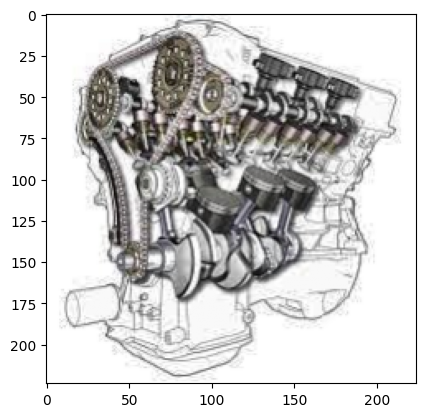



1 [0 1 0 0] ['Elevation']


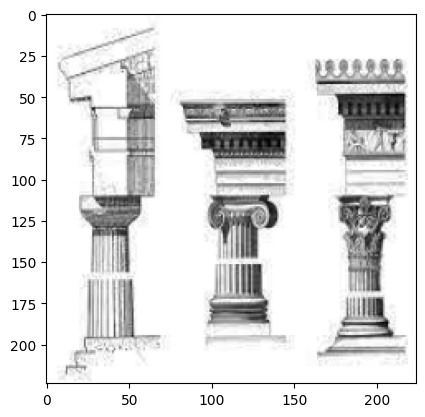



2 [0 0 1 0] ['Section']


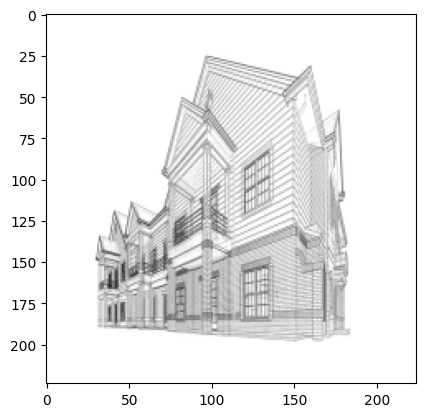



3 [1 0 0 0] ['Plan']


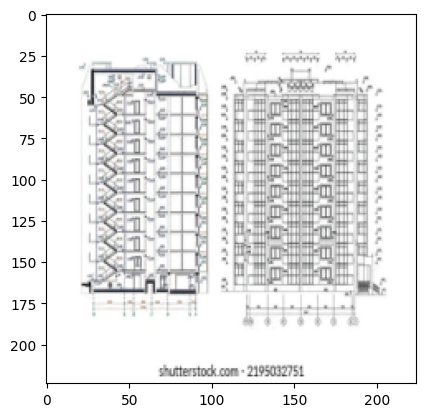



4 [0 1 0 0] ['Elevation']


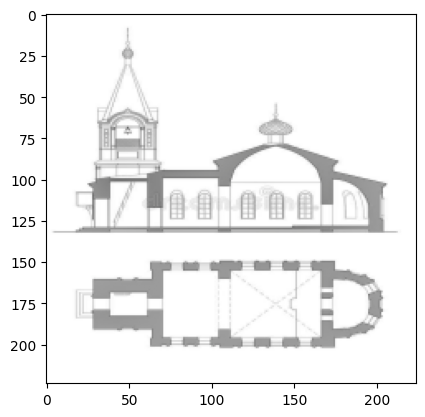



5 [1 1 1 0] ['Plan', 'Elevation', 'Section']


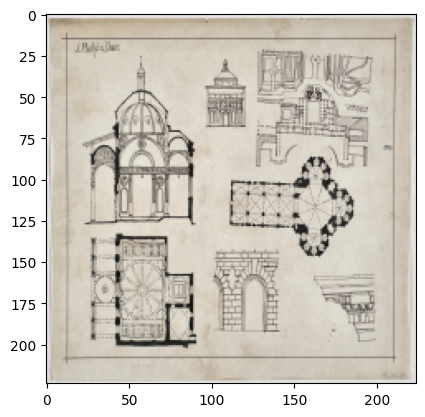



6 [0 0 1 0] ['Section']


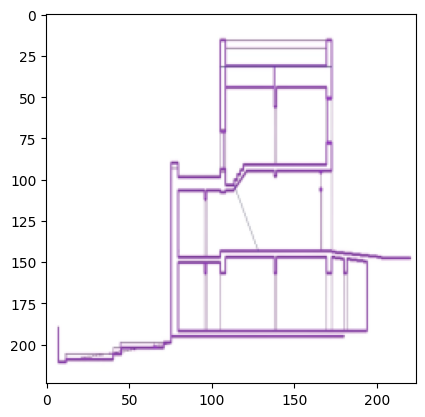



7 [0 1 0 0] ['Elevation']


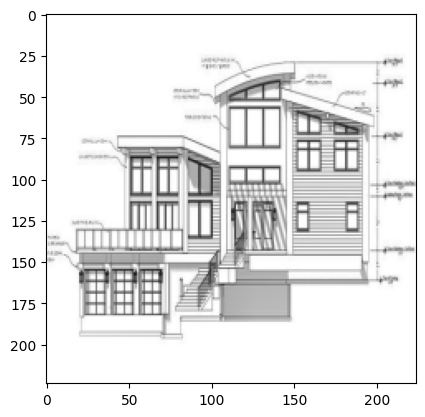



8 [0 1 0 0] ['Elevation']


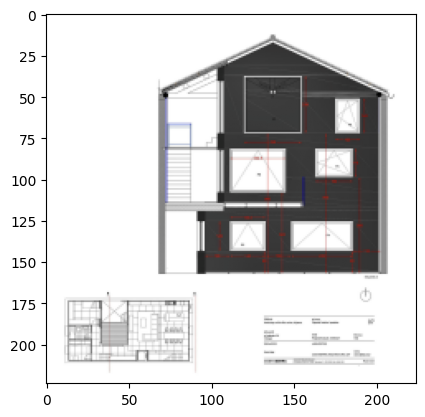



9 [1 0 0 0] ['Plan']


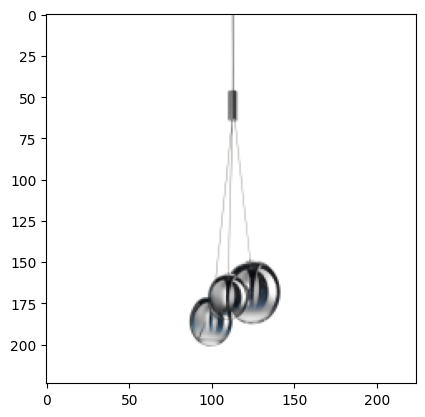



10 [0 0 0 1] ['Others']


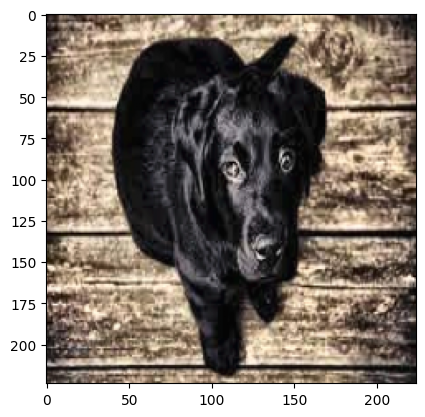



11 [0 0 0 1] ['Others']


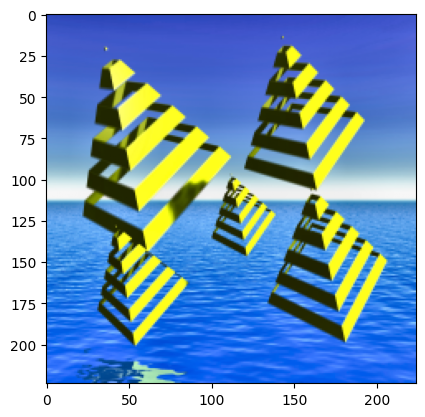



12 [1 1 0 0] ['Plan', 'Elevation']


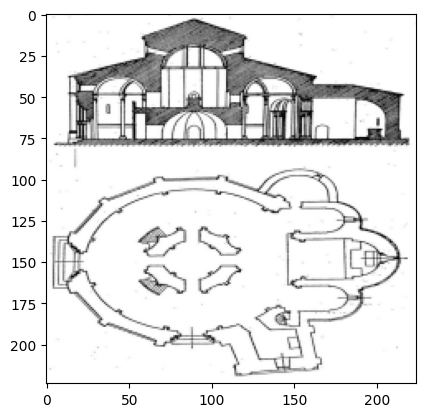



13 [0 1 0 0] ['Elevation']


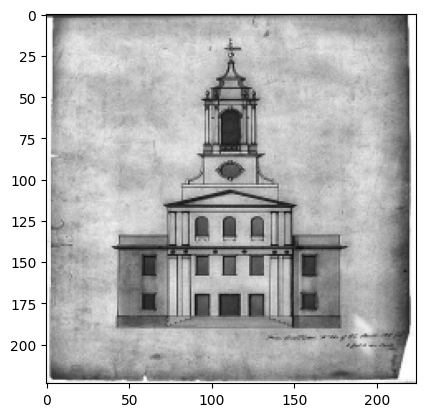



14 [1 0 0 0] ['Plan']


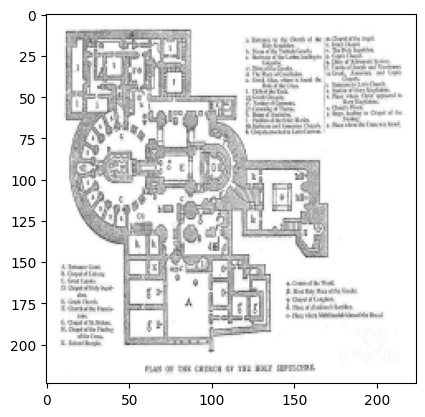



15 [1 1 1 0] ['Plan', 'Elevation', 'Section']


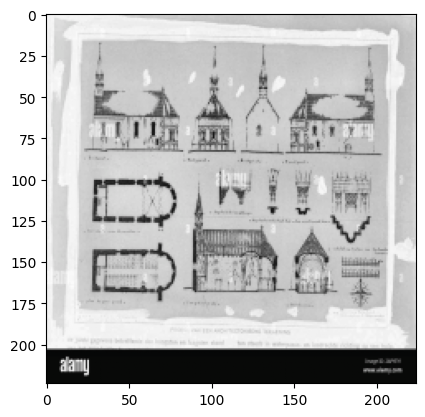



16 [0 0 1 0] ['Section']


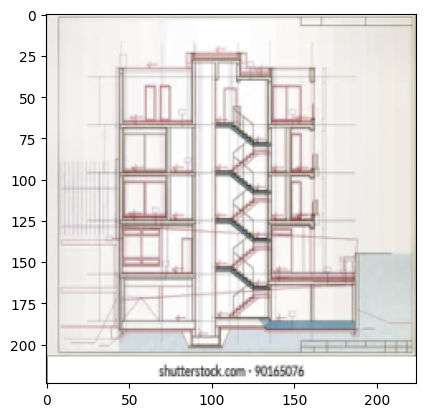



17 [0 0 0 1] ['Others']


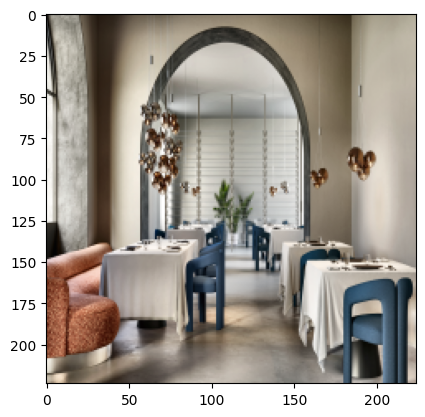



18 [0 0 0 1] ['Others']


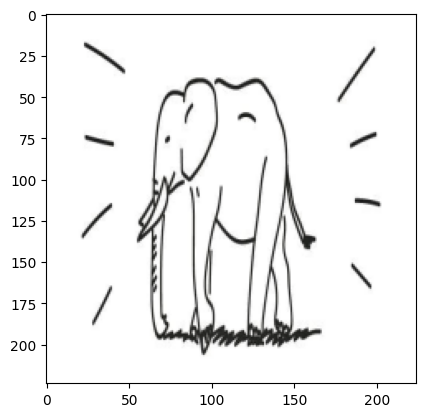



19 [0 0 1 0] ['Section']


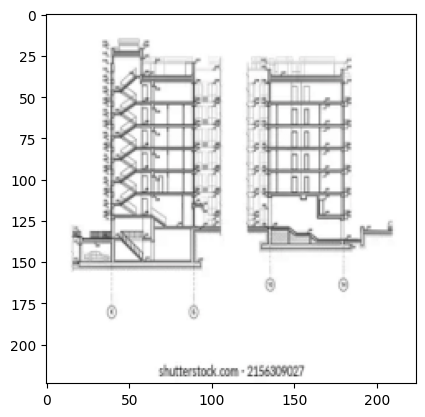



20 [1 0 0 1] ['Plan', 'Others']


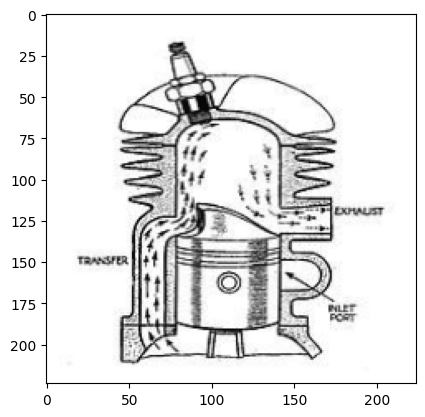



21 [1 0 0 0] ['Plan']


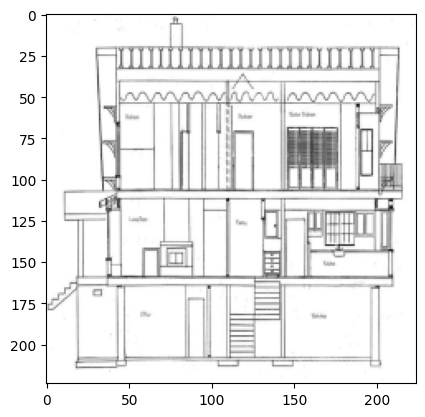



22 [0 1 0 0] ['Elevation']


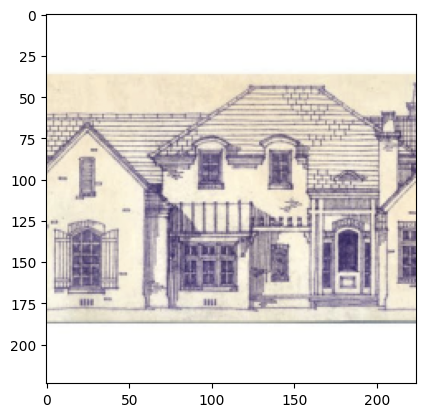



23 [1 1 0 0] ['Plan', 'Elevation']


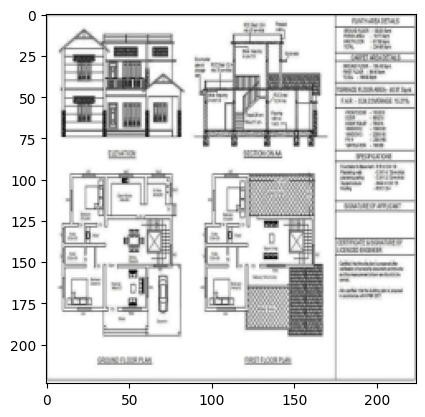



24 [0 0 1 0] ['Section']


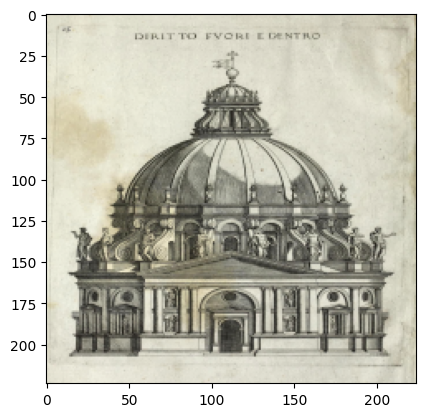



25 [1 0 0 0] ['Plan']


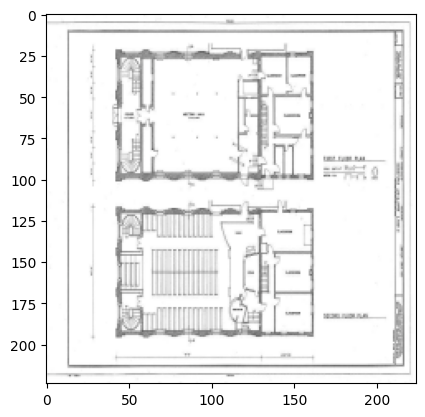



26 [1 1 0 0] ['Plan', 'Elevation']


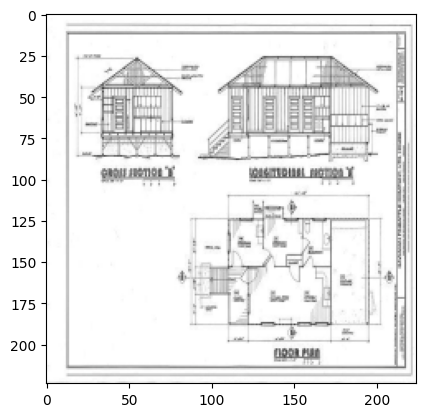



27 [0 1 0 0] ['Elevation']


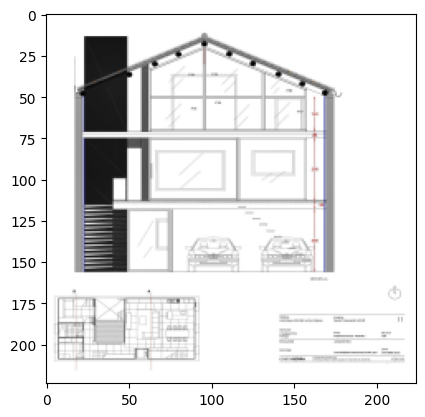



28 [0 0 1 0] ['Section']


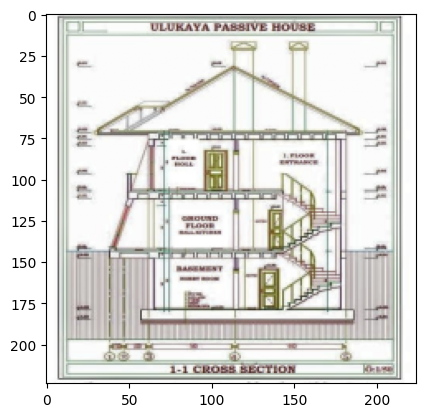



29 [0 0 1 0] ['Section']


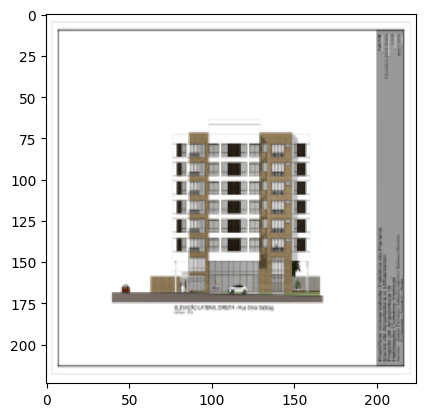



30 [0 1 1 0] ['Elevation', 'Section']


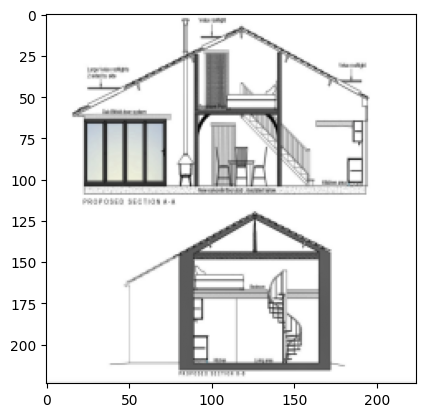



31 [1 0 0 0] ['Plan']


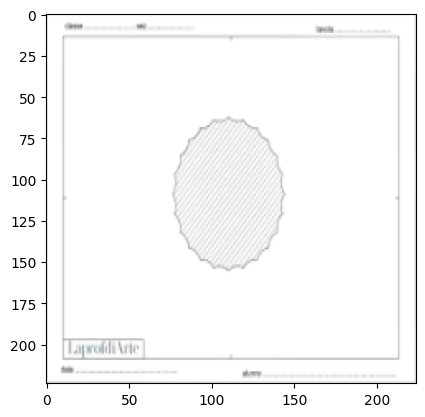



32 [1 0 0 0] ['Plan']


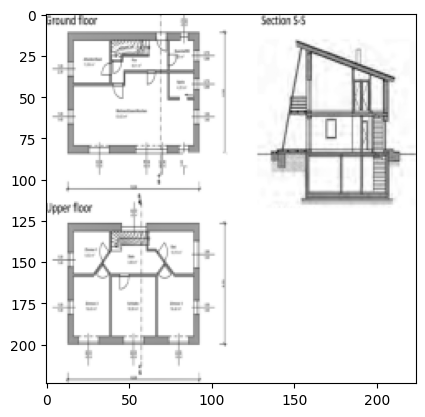



33 [0 1 0 0] ['Elevation']


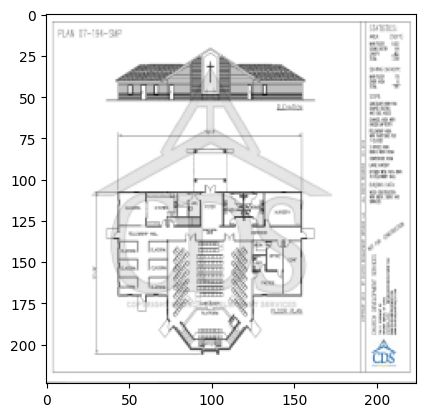



34 [1 0 0 0] ['Plan']


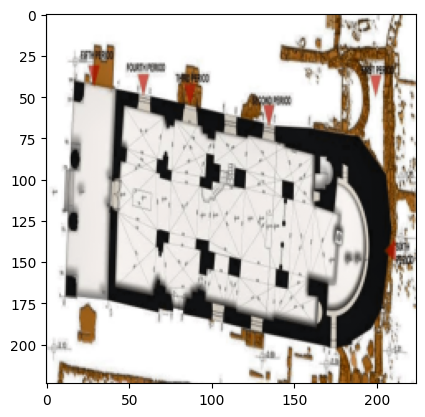

In [ ]:
from matplotlib import pyplot as plt

for idx, pred in enumerate(y_pred):
  print(idx, pred, list(np.array(LABELS)[pred==1]))
  plt.imshow(image_list[idx]/255)
  plt.show()
  print('\n')